# Question 2

In this question we will:
- Implement the vector median filter for colour images.
- Apply the vector median filter to a small dataset and establish a baseline performance meteric.
- Try to design a denoising pipeline that outperforms using only the vector median filter.   

In [1]:
# Boilerplate imports
import skimage.io as skio
import skimage.color as skcolor
import skimage.util as skutil
import skimage.restoration as skrest
import skimage.filters as skfilt
import skimage.metrics as skmetrics
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

np.random.seed(0)

# Step 1: Implement the vector median filter for colour images.

## Instructions

- Write a function that implements the vector median filter.  Details on the vector median filter can be found in Topic 4 of the lecture notes and implementation suggestions can be found in Section 2 of the asignment PDF.  
- The parameters to your function should be the input image `I`, and the `radius` of the square neighbourhood, e.g. radius 1 = 3x3 filter, radius 2 = 5x5 filter, etc.
- Your function should accept images of dtype `uint8` or `float64` (other types may be rejected if you wish).    It is easiest if you work with the image as data type `float64`.   If the input image is of type `uint8`, it is suggested that you convert it to dtype `float64`, construct the output image also as type `float64` and then convert it back to `uint8` before returning it.  In any case, the output image returned should be the same dtype as the input image.

In [2]:
def vector_median(I, radius):
    # Type Check
    if I.dtype not in [np.uint8, np.float64]:
        raise ValueError("Image type not supported. Must be uint8 or float64")

    # Valid radius
    if radius < 1:
        raise ValueError("Radius must be greater than or equal to 1")

    # Convert uint8 to float64
    is_uint8 = I.dtype == np.uint8
    if is_uint8:
        I = skutil.img_as_float(I)

    # Get dimensions
    height, width, channels = I.shape
    output = np.zeros_like(I)  # Stores the output image

    # Add padding to handle borders
    I_padded = np.pad(
        I, 
        (
            (radius, radius),  # Pad top and bottom
            (radius, radius),  # Pad left and right
            (0, 0)  # Don't pad the channels
        ), 
        mode='edge'  # Extend the border values
    )

    # Iterate in raster order
    for y in range(height):
        for x in range(width):
            # Adjust x, y for them to start in the image and not the padding
            x_pad = x + radius
            y_pad = y + radius

            # Extract the neighborhood
            neighbourhood = I_padded[
                                y_pad - radius:y_pad + radius + 1,  # +1 bc slicing is exclusive
                                x_pad - radius:x_pad + radius + 1, 
                                :
                            ]

            # Each row is a color vector
            n_pixels = neighbourhood.shape[0] * neighbourhood.shape[1]
            colors = np.reshape(neighbourhood, (n_pixels, 3))

            Y = np.tile(
                np.reshape(colors, (n_pixels, 1, 3)),
                (1, n_pixels, 1)
            )

            # Construct the second matrix X so that it also has n planes of size n × 3, but where the i-th plane contains n copies of just one of the colours in the neighbourhood
            X = np.tile(
                np.reshape(colors, (1, n_pixels, 3)),
                (n_pixels, 1, 1)
            )

            # Compute Manhattan distances across all pairs
            distances = np.sum(np.abs(X - Y), axis=2)

            # Find the index of the color vector with the minimum distance sum
            min_index = np.argmin(np.sum(distances, axis=1))

            # The output pixel is the color with the minimum Manhattan distance
            output[y, x, :] = colors[min_index]

    # Convert back to uint8 if needed
    if is_uint8:
        return skutil.img_as_ubyte(output)
    else:
        return output

# Step 2a: Establish a Baseline

## Instructions

- Determine the PSNR and SSIM of all of the noisy images by comparing them to their noiseless versions -- store these in a list.  
    - Use the same method to read the images files as in question 1, but read them from the `images/noisy` directory and the `images/noiseless` directory as needed.
- Filter each noisy image with a 3x3 vector median filter and compute the PSNR and SSIM of all of the filtered noisy images (by comparing them to the noiseless images) -- store these in a list.   
    - As with question 1, to save time we recommend you develop and debug your programs using only the first three to five images in file_list, and run it on the complete list when you're done. 
- The noiseless images are provided so you can compute PSNR and SSIM.  See functions `skmetrics.peak_signal_noise_ratio()` and `skmetrics.structural_similarity()`.  You'll need the `channel_axis=2` argument for `structural_similarity()`.  This indicates to the function that the it is the 3rd dimension of the 3D arrays that index the R, G and B channels.

_Hint: This step requires doing a few seemingly different things, but it's actually easier to do them all at once in the same loop._



In [3]:
psnr = {'noisy': [], 'filtered': []}
ssim = {'noisy': [], 'filtered': []}

In [4]:
file_list = pd.read_csv('data/images.csv', header=None)
file_list = file_list[0].tolist()

In [5]:
noiseless_dir = 'data/images/noiseless'
noisy_dir = 'data/images/noisy'

In [6]:
for filename in file_list:
    noiseless_path = os.path.join(noiseless_dir, filename)
    noisy_path = os.path.join(noisy_dir, filename)
    
    # Read the images
    noiseless = skio.imread(noiseless_path)
    noiseless = skutil.img_as_float(noiseless)
    
    noisy = skio.imread(noisy_path)
    noisy = skutil.img_as_float(noisy)
    
    # PSNR and SSIM for the noisy/noiseless image
    psnr_noisy = skmetrics.peak_signal_noise_ratio(noiseless, noisy)
    ssim_noisy = skmetrics.structural_similarity(noiseless, noisy, data_range=1, channel_axis=2)
    
    # Filter the noisy image
    filtered = vector_median(noisy, 1)
    
    # PSNR and SSIM for the filtered/noiseless image
    psnr_filtered = skmetrics.peak_signal_noise_ratio(noiseless, filtered)
    ssim_filtered = skmetrics.structural_similarity(noiseless, filtered, data_range=1, channel_axis=2)
    
    psnr['noisy'].append(psnr_noisy)
    psnr['filtered'].append(psnr_filtered)
    ssim['noisy'].append(ssim_noisy)
    ssim['filtered'].append(ssim_filtered)

# Step 2b: Compute average baseline metrics.

## Instructions

Compute the average PSNR and SSIM for the unfiltered noisy images (take the PSNR and SSIM measures for each image and average them).  Do the same for the median-filtered noisy images.  Plot a bar graph showing the two mean PSNR values and another showing the two mean SSIM values before and after filtering (see assignment description for sample output).

The PSNR and SSIM of the noisy images was computed on the cell above due to simplicity.

In [7]:
# Average PSNR and SSIM for the noisy and filtered images
psnr_noisy_mean = np.mean(psnr['noisy'])
psnr_filtered_mean = np.mean(psnr['filtered'])

ssim_noisy_mean = np.mean(ssim['noisy'])
ssim_filtered_mean = np.mean(ssim['filtered'])

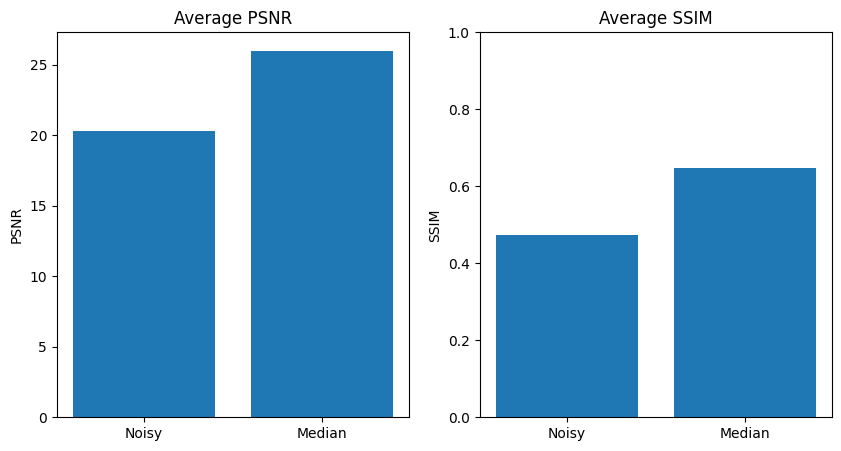

In [8]:
_, axes = plt.subplots(1, 2, figsize=(10, 5))
# PSNR
axes[0].bar(['Noisy', 'Median'], [psnr_noisy_mean, psnr_filtered_mean])
axes[0].set_title("Average PSNR")
axes[0].set_ylabel("PSNR")

# SSIM
axes[1].bar(['Noisy', 'Median'], [ssim_noisy_mean, ssim_filtered_mean])
axes[1].set_title("Average SSIM")
axes[1].set_ylabel("SSIM")
axes[1].set_ylim(0, 1)
plt.show()

# Step 3:  See if you can do better!

Find a better way to denoise the images.  Compute the mean PSNR and SSIM for your denoising method.   Replot the graphs in the previous step with the new results added.

_You can use any functions in the python libraries to help you (numpy, scipy, skimage, etc.) but you cannot bring in code from external sources._


There's a lot of __salt and pepper__ noise in the images. I'll try to remove it using a median filter and then apply a gaussian filter to smooth the image.

In [9]:
def denoise_custom(I):
    # Type Check
    if I.dtype not in [np.uint8, np.float64]:
        raise ValueError("Image type not supported. Must be uint8 or float64")

    # If uint8, convert to float64
    is_uint8 = I.dtype == np.uint8
    if is_uint8:
        I = skutil.img_as_float(I)

    # Apply median filter
    denoised = skfilt.median(
        I, 
        footprint=np.ones((3, 3, 1))  # 3x3 filter
    )
    
    # Apply gaussian filter
    denoised = skfilt.gaussian(denoised, sigma=1, channel_axis=2)

    if is_uint8:  # Convert back to uint8 if necessary
        return skutil.img_as_ubyte(denoised)
    else:
        return denoised

In [10]:
psnr_custom = []
ssim_custom = []

In [11]:
for filename in file_list:
    noiseless_path = os.path.join(noiseless_dir, filename)
    noisy_path = os.path.join(noisy_dir, filename)
    
    # Read the images
    noiseless = skio.imread(noiseless_path)
    noiseless = skutil.img_as_float(noiseless)
    
    noisy = skio.imread(noisy_path)
    noisy = skutil.img_as_float(noisy)
    
    # Filter the noisy image
    filtered = denoise_custom(noisy)
    
    # Compute PSNR and SSIM for the filtered image
    psnr_filtered = skmetrics.peak_signal_noise_ratio(noiseless, filtered)
    ssim_filtered = skmetrics.structural_similarity(noiseless, filtered, data_range=1, channel_axis=2)
    
    # Store the results
    psnr_custom.append(psnr_filtered)
    ssim_custom.append(ssim_filtered)

In [12]:
psnr_custom_mean = np.mean(psnr_custom)
ssim_custom_mean = np.mean(ssim_custom)

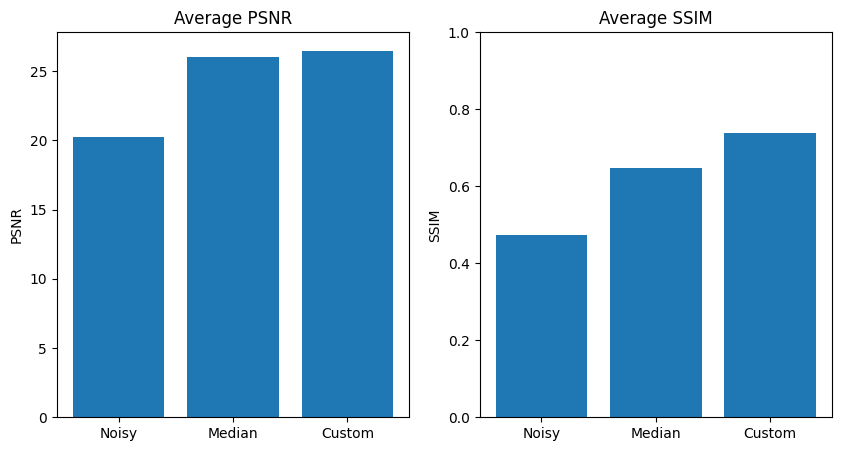

In [13]:
_, axes = plt.subplots(1, 2, figsize=(10, 5))

# PSNR
axes[0].bar(['Noisy', 'Median', 'Custom'], [psnr_noisy_mean, psnr_filtered_mean, psnr_custom_mean])
axes[0].set_title("Average PSNR")
axes[0].set_ylabel("PSNR")
    
# SSIM
axes[1].bar(['Noisy', 'Median', 'Custom'], [ssim_noisy_mean, ssim_filtered_mean, ssim_custom_mean])
axes[1].set_title("Average SSIM")
axes[1].set_ylabel("SSIM")
axes[1].set_ylim(0, 1)
plt.show()